In [27]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [28]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

In [29]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [30]:
adj_close_df = pd.DataFrame()


In [31]:
for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate, auto_adjust = False )
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2010-03-05   86.724800  51.907173  110.809998   40.563667   44.434643
2010-03-08   86.739990  51.822258  109.879997   40.642265   44.442284
2010-03-09   86.884193  51.854923  109.720001   40.869370   44.533878
2010-03-10   87.271324  51.815731  108.470001   41.201286   44.770512
2010-03-11   87.635704  51.809147  108.599998   41.358501   44.938473
...                ...        ...         ...         ...         ...
2025-02-24  597.210022  72.870003  272.209991  519.869995  294.410004
2025-02-25  594.239990  73.330002  268.619995  513.320007  292.950012
2025-02-26  594.539978  73.440002  269.029999  514.559998  293.049988
2025-02-27  585.049988  73.349998  264.929993  500.269989  288.510010
2025-02-28  594.179993  73.660004  263.269989  508.170013  292.959991

[3771 rows x 5 columns]


Calculate log return and drop n/a

In [32]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-03-08  0.000175 -0.001637 -0.008428  0.001936  0.000172
2010-03-09  0.001661  0.000630 -0.001457  0.005572  0.002059
2010-03-10  0.004446 -0.000756 -0.011458  0.008089  0.005299
2010-03-11  0.004167 -0.000127  0.001198  0.003809  0.003745
2010-03-12  0.000086  0.000379 -0.006003  0.000211  0.000000
...              ...       ...       ...       ...       ...
2025-02-24 -0.004561  0.001373  0.005415 -0.011875 -0.005116
2025-02-25 -0.004986  0.006293 -0.013276 -0.012679 -0.004971
2025-02-26  0.000505  0.001499  0.001525  0.002413  0.000341
2025-02-27 -0.016091 -0.001226 -0.015357 -0.028164 -0.015613
2025-02-28  0.015485  0.004217 -0.006286  0.015668  0.015306

[3770 rows x 5 columns]


In [33]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


historical returns with equal weights

In [34]:
historical_returns = (log_returns*weights).sum(axis = 1)
print(historical_returns)

Date
2010-03-08   -0.001557
2010-03-09    0.001693
2010-03-10    0.001124
2010-03-11    0.002558
2010-03-12   -0.001065
                ...   
2025-02-24   -0.002953
2025-02-25   -0.005924
2025-02-26    0.001257
2025-02-27   -0.015290
2025-02-28    0.008878
Length: 3770, dtype: float64


Find the X-day historical returns (rolling average of 5 days)

In [35]:
days = 5 

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2010-03-12    0.002753
2010-03-15    0.004822
2010-03-16    0.011689
2010-03-17    0.012147
2010-03-18    0.010934
                ...   
2025-02-24   -0.010703
2025-02-25   -0.020768
2025-02-26   -0.020709
2025-02-27   -0.033588
2025-02-28   -0.014032
Length: 3766, dtype: float64


Let's Specify a confidence interval and calculate the Value at Risk (VaR) using historical method. (-np.percentile(range_returns, 100 - (confidence_interval * 100))) gives you VaR in returns and we * by PF value in order to bring it in USD

In [36]:
confidence_interval = 0.99

VaR = -np.percentile(range_returns, 100 - (confidence_interval * 100)) * portfolio_value
print(VaR)

43658.55747431603


Let's Plot the VaR

<function matplotlib.pyplot.show(close=None, block=None)>

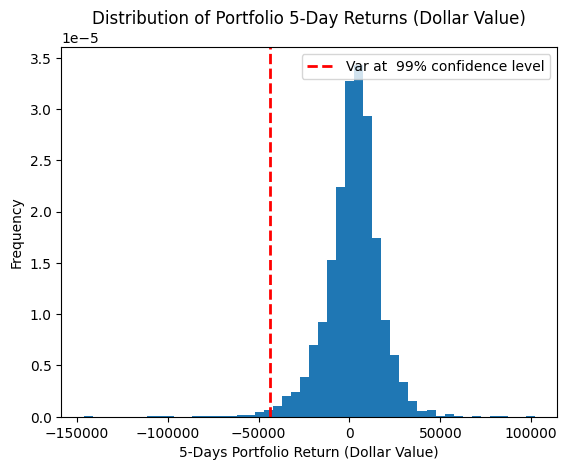

In [38]:
return_window = days
range_returns = historical_returns.rolling(window = return_window).sum()
range_returns = range_returns.dropna()

range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins = 50, density = True)
plt.xlabel(f'{return_window}-Days Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR, color = 'r', linestyle = 'dashed', linewidth = 2, label = f'Var at {confidence_interval: .0%} confidence level')
plt.legend()
plt.show